**SigNet Siamese Model**


**Dataset**

Dataset used is the CEDAR Signature Dataset 

Dataset Link :     [CEDAR](http://www.cedar.buffalo.edu/NIJ/data/signatures.rar)

In [1]:
!wget -N -P . http://www.cedar.buffalo.edu/NIJ/data/signatures.rar

--2022-06-08 16:22:56--  http://www.cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving www.cedar.buffalo.edu (www.cedar.buffalo.edu)... 128.205.33.100
Connecting to www.cedar.buffalo.edu (www.cedar.buffalo.edu)|128.205.33.100|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cedar.buffalo.edu/NIJ/data/signatures.rar [following]
--2022-06-08 16:22:57--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./signatures.rar’ not modified on server. Omitting download.



In [2]:
!unrar x -inul signatures.rar

In [1]:
import tensorflow
import tensorflow as tf
from tensorflow import keras
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(tensorflow.__version__)
print(keras.__version__)
print(pd.__version__)
print(cv2.__version__)
print(np.__version__)

2.9.1
2.9.0
1.4.2
4.5.5
1.21.5


**DataFrame Generator**

Generates a pandas dataframe with path of the signature samples that are used in this model.

Generates pairs of signatures in the form of Genuine-Genuine and Genuine-Forged

Total Samples = Number of Persons * Number of Samples * Types of Pairs(2)

          Total Samples    = 55 * 24 * 2 = 2640 

In [2]:
path_org =  'signatures/full_org'
path_forg = 'signatures/full_forg'
no_persons = 55
no_signs = 24

def create_df():
  org_sign = []
  for i in range(1,no_persons+1):
    for j in range(1,no_signs+1):
      path = (path_org+'/original_'+str(i)+'_'+str(j)+'.png')
      org_sign.append(path)

  forg_sign = []
  for i in range(1,no_persons+1):
    for j in range(1,no_signs+1):
      path = (path_forg+'/forgeries_'+str(i)+'_'+str(j)+'.png')
      forg_sign.append(path)

  
  raw_data = {"input_1":[], "input_2":[], "label":[]}
  for i in range(no_persons):
    org_signs_1=[]
    org_signs_2=[]
    forg_signs_1=[]

    start = i*24
    end = (i+1)*24

    for sample in range(start,end): 
      org_signs_1.append(org_sign[sample])
      org_signs_2.append(org_sign[sample])
      raw_data["label"].append(1) 
    
    org_signs_1.extend(org_signs_2)

    for sign in org_signs_2:
      forg_signs_1.append(sign)
    
    for j in range(start,end): 
      forg_signs_1.append(forg_sign[j])
      raw_data["label"].append(0)
    
    raw_data["input_1"].extend(org_signs_1)
    raw_data["input_2"].extend(forg_signs_1)

  df = pd.DataFrame(raw_data, columns = ["input_1","input_2","label"])
  return df

**Dataset Split**

Splitting the data into train, validation and test data with a ratio  6:2:2

Train data = 0.6 * 2640 = 1584

Validation data = 0.4 * 0.5 * 2640 = 528

Testing data = 0.4 * 0.5 * 2640 = 528


In [3]:
def train_test_dataset():
  data_frame = create_df()
  train_set, res_set = train_test_split(data_frame,train_size=0.6,random_state=0)
  validation_set, test_set = train_test_split(res_set,train_size=0.5,random_state=0)

  return train_set, validation_set, test_set

train_set,validation_set, test_set = train_test_dataset()
print(train_set.size, validation_set.size, test_set.size)
print("The number of instances in train set",train_set.shape[0])
print("The number of instances in validation set",validation_set.shape[0])
print("The number of instances in test set",test_set.shape[0])

4752 1584 1584
The number of instances in train set 1584
The number of instances in validation set 528
The number of instances in test set 528


**Processing The Signatures**


In [4]:
def sig_process(inp):
  
  inp = cv2.resize(inp,(220,155))
  inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
  ret,inp = cv2.threshold(inp, 0, 255, cv2.THRESH_OTSU)
  inp = inp/255
  inp = inp[:, :, np.newaxis]
  inp = np.array(inp)

  return inp

**Input Generator for the Model**

In [5]:
class generate(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size, dimension):
        self.dimension = dimension
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]

        self.on_epoch_end()
    
    def __len__(self):
        s_df=self.df.shape[0]
        n=np.floor(s_df/self.batch_size)
        return int(n)

    def __getitem__(self, ind):
        batches = self.indices[ind*self.batch_size:(ind+1)*self.batch_size]
        items = [self.df.iloc[k] for k in batches]
        part1,part2 = self.generator(items)
        return part1,part2

    def on_epoch_end(self):
        self.indices = np.arange(self.df.shape[0])

    def generator(self, items):
        part_1 = np.empty((self.batch_size, *self.dimension,1))
        part_2 = np.empty((self.batch_size, *self.dimension,1))
        label = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(items)):

            input_1 = cv2.imread(items[i]["input_1"])
            input_1 = sig_process(input_1) 

            input_2 = cv2.imread(items[i]["input_2"])
            input_2 = sig_process(input_2)

            label[i] = items[i]["label"]
            part_1[i,] = input_1
            part_2[i,] = input_2 
            
        return [part_1 ,part_2], label

In [6]:
dimension = (155,220)
batch_size = 64
data_training = generate(train_set,batch_size,dimension)
data_validation = generate(validation_set,batch_size,dimension)

**Functions Used**

In [7]:
from tensorflow.keras import backend as K

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(l, y_pred):
    margin = 1
    l = tf.cast(l, y_pred.dtype)
    margin_square = (K.maximum(margin - y_pred, 0))**2
    return K.mean((l * (y_pred)**2)*l + (1 - l)* margin_square)
    
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

**SigNet Model**

In [8]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation, Input, Dropout, Flatten, BatchNormalization, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model

def signet_model():
    
    input_shape=(155,220,1)
    input_1 = Input(shape=input_shape, name="input_1")
    input_2 = Input(shape=input_shape, name="input_2")  
    
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    model.add(MaxPool2D((3,3), strides=(2, 2)))    
    model.add(ZeroPadding2D((2, 2)))
    
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    model.add(MaxPool2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))
    model.add(ZeroPadding2D((1, 1)))
    
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform'))
    model.add(ZeroPadding2D((1, 1)))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform'))    
    model.add(MaxPool2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    
    
    model.summary()
    plot_model(model, to_file='sequential.png', show_shapes=True, show_layer_names=True)

    branch1 = model(input_1)
    branch2 = model(input_2)

    cal = Lambda(euclidean_distance,output_shape=output_shape)
    distance=cal([branch1, branch2])

    model = Model([input_1, input_2], distance)

    return model

In [12]:
model = signet_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 37, 53, 96)        11712     
                                                                 
 batch_normalization_2 (Batc  (None, 37, 53, 96)       148       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 26, 96)       0         
 2D)                                                             
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 22, 30, 96)       0         
 ng2D)                                                           
                                                                 
 conv2_1 (Conv2D)            (None, 18, 26, 256)       614656    
                                                      

In [13]:
#img = cv2.imread('sequential_model.png')
#print("The Layers in Sequential API are \n")
#cv2_imshow(img)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          6461084     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

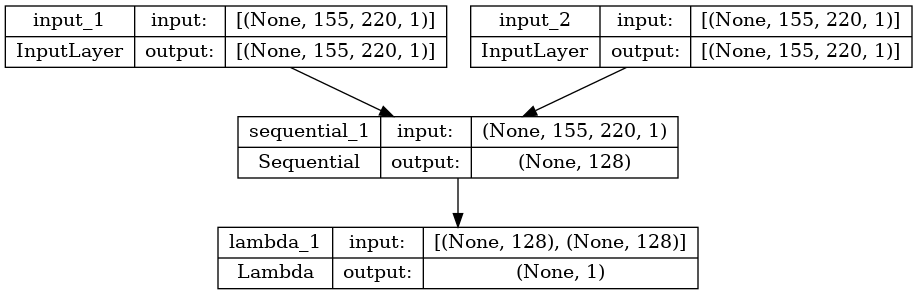

In [14]:
model.summary()
print("The layers in the SigNet Network Model are \n")
tf.keras.utils.plot_model(model, to_file="base_model.png", show_shapes=True)

**Training the Model**

In [15]:
rms = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [16]:
history=model.fit(data_training, validation_data = data_validation, epochs= 50)

Epoch 1/50


2022-06-18 22:38:38.074221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


24/24 [==============================] - 13s 393ms/step - loss: 13.6215 - accuracy: 0.4948 - val_loss: 1.3767 - val_accuracy: 0.5098
Epoch 2/50
24/24 [==============================] - 9s 370ms/step - loss: 1.2295 - accuracy: 0.4935 - val_loss: 1.3858 - val_accuracy: 0.5098
Epoch 3/50
24/24 [==============================] - 9s 368ms/step - loss: 1.1616 - accuracy: 0.5091 - val_loss: 1.3655 - val_accuracy: 0.5098
Epoch 4/50
24/24 [==============================] - 9s 369ms/step - loss: 1.1571 - accuracy: 0.5111 - val_loss: 1.3481 - val_accuracy: 0.5098
Epoch 5/50
24/24 [==============================] - 9s 376ms/step - loss: 1.1414 - accuracy: 0.5176 - val_loss: 1.3356 - val_accuracy: 0.5098
Epoch 6/50
24/24 [==============================] - 9s 390ms/step - loss: 1.1163 - accuracy: 0.4993 - val_loss: 1.2985 - val_accuracy: 0.5098
Epoch 7/50
24/24 [==============================] - 9s 386ms/step - loss: 1.0586 - accuracy: 0.5208 - val_loss: 1.2394 - val_accuracy: 0.5098
Epoch 8/50
24/2

In [17]:
model.save('signet_model.h5')

**Plotting graphs for Accuracy and Loss**

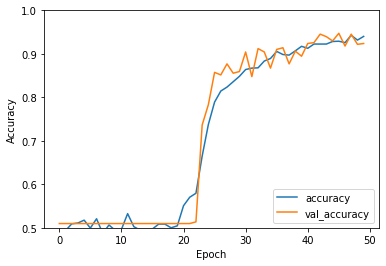

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("accuracy_plot.png")

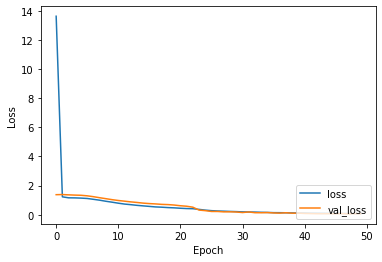

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig("loss_plot.png")

**Evaluating the validation accuracy and Validation loss**

In [20]:
validation_loss, validation_acc = model.evaluate(data_validation)

8/8 [==============================] - 2s 296ms/step - loss: 0.0689 - accuracy: 0.9238


In [21]:
print("The validation loss is = ",validation_loss)

The validation loss is =  0.06893716752529144


In [22]:
print("The validation accuracy is = ",validation_acc)

The validation accuracy is =  0.923828125


**Evaluating the Test accuracy and Test loss**

In [23]:
data_test = generate(test_set,batch_size,dimension)

test_loss, test_acc = model.evaluate(data_test)

8/8 [==============================] - 2s 304ms/step - loss: 0.0798 - accuracy: 0.9023


In [24]:
print("The testing loss is = ",test_loss)

The testing loss is =  0.07982411235570908


In [25]:
print("The testing accuracy is = ",test_acc)

The testing accuracy is =  0.90234375


In [26]:
print('Original Signature Details :\n')
s = input('Enter signer number(1 to 55) : ')
s1 = input('Enter signature Sample number for signer number '+s+'(1 to 24) : ')

print('\n Test Signature Details : \n')
type=input('Enter forg for forged and org for genuine signature : ')
s2=input('Enter signature number for signer number '+s+'(1 to 24) : ') 

if(type=='forg'):
  st='forgeries'
elif(type=='org'):
  st='original'

inp1 = cv2.imread('signatures/full_org/original_'+s+'_'+s1+'.png')
inp2 = cv2.imread('signatures/full_'+type+'/'+st+'_'+s+'_'+s2+'.png')

inp1 = sig_process(inp1)
inp2 = sig_process(inp2)

inp1 = np.expand_dims(inp1,axis=0)
inp2 = np.expand_dims(inp2,axis=0)

inp_pred = model.predict([inp1,inp2])
inp_pred = np.round(inp_pred)

print(inp_pred)

if (inp_pred[0][0] == 0):
  print('The second signature is genuine \n')
elif(inp_pred[0][0]>=1):
  print('The second signature is forged \n')


Original Signature Details :



Enter signer number(1 to 55) :  5
Enter signature Sample number for signer number 5(1 to 24) :  5



 Test Signature Details : 



Enter forg for forged and org for genuine signature :  forg
Enter signature number for signer number 5(1 to 24) :  5


1/1 [==============================] - 0s 382ms/step
[[1.]]
The second signature is forged 

